In [1]:
import pandas as pd
ichroCNA_file = '/Users/irf3irf3/Desktop/offline_workspace/data/GBM/Batch2/gbm_default_tf.txt'
manifest_file = '/Users/irf3irf3/Desktop/offline_workspace/data/GBM/Batch2/2024-01-25 Hong Chen lab patient samples manifest_irf.xlsx'

ichorCNA_df = pd.read_csv(ichroCNA_file, sep='\t')
manifest_df = pd.read_excel(manifest_file, sheet_name='Glance')
display(ichorCNA_df.head())

,library,tumor_fraction,ploidy,gender,ChrY_coverage_fraction,ChrX_median_log_ratio
0,Sample_100,0.05698,2.087,female,0.0,-1.0050
1,Sample_103,0.00000,2.041,female,0.0,-0.9949
2,Sample_69,0.06856,2.003,female,0.0,-1.0120
3,Sample_95,0.00000,2.057,female,0.0,-1.0020
4,Sample_H01_B01,0.00000,2.024,female,0.0,-1.0020


In [2]:
ichorCNA_df['library'] = ichorCNA_df['library'].str.replace('Sample_', '', regex=False)
ichorCNA_df['library'] = ichorCNA_df['library'].str.replace('_', '', regex=False)
display(ichorCNA_df.head())

,library,tumor_fraction,ploidy,gender,ChrY_coverage_fraction,ChrX_median_log_ratio
0,100,0.05698,2.087,female,0.0,-1.0050
1,103,0.00000,2.041,female,0.0,-0.9949
2,69,0.06856,2.003,female,0.0,-1.0120
3,95,0.00000,2.057,female,0.0,-1.0020
4,H01B01,0.00000,2.024,female,0.0,-1.0020


In [3]:
def filter_data(df,manifest_df, time_point):
    filtered_data = df[df['library'].str.startswith('H')]
    # Filter manifest_df for the specific time_point
    filtered_manifest = manifest_df[manifest_df['Time Points'] == time_point]
    
   # print(filtered_manifest['Sample name'])
    # Filter ichorCNA_df based on the 'library' values that match the filtered manifest
    filtered_data = filtered_data[filtered_data['library'].isin(filtered_manifest['Sample name'])]
    return filtered_data

In [4]:
pre5 = filter_data(ichorCNA_df,manifest_df, 'Pre-FUS 5min')
pre10 = filter_data(ichorCNA_df,manifest_df, 'Pre-FUS 10min')
post5 = filter_data(ichorCNA_df,manifest_df, 'Post-FUS 5min')
post10 = filter_data(ichorCNA_df,manifest_df, 'Post-FUS 10min')
post30 = filter_data(ichorCNA_df,manifest_df, 'Post-FUS 30min')



,base_sample,tumor_fraction_pre10,tumor_fraction_pre5,tumor_fraction_post5,tumor_fraction_post10,tumor_fraction_post30
0,H06,0.00000,0.03155,0.00000,0.05830,0.00000
1,H07,0.04607,0.06142,0.05375,0.05377,0.06580
2,H08,0.03707,0.00000,0.03001,0.03355,0.03095
3,H09,0.02439,0.03774,0.03941,0.04337,0.04365
4,H10,0.06561,0.00000,0.00000,0.00000,0.00000
5,H11,0.00000,0.00000,0.00000,0.00000,0.00000
6,H12,0.00000,0.05931,0.00000,0.00000,0.02318


/var/folders/2f/dgzn6jc90s7b4k56lfc468600000gq/T/ipykernel_1951/3515578270.py:33: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x='time', y='tumor_fraction', data=plot_df, join=False, errorbar=None, markers='d', scale=0, color='black')
/var/folders/2f/dgzn6jc90s7b4k56lfc468600000gq/T/ipykernel_1951/3515578270.py:33: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='time', y='tumor_fraction', data=plot_df, join=False, errorbar=None, markers='d', scale=0, color='black')


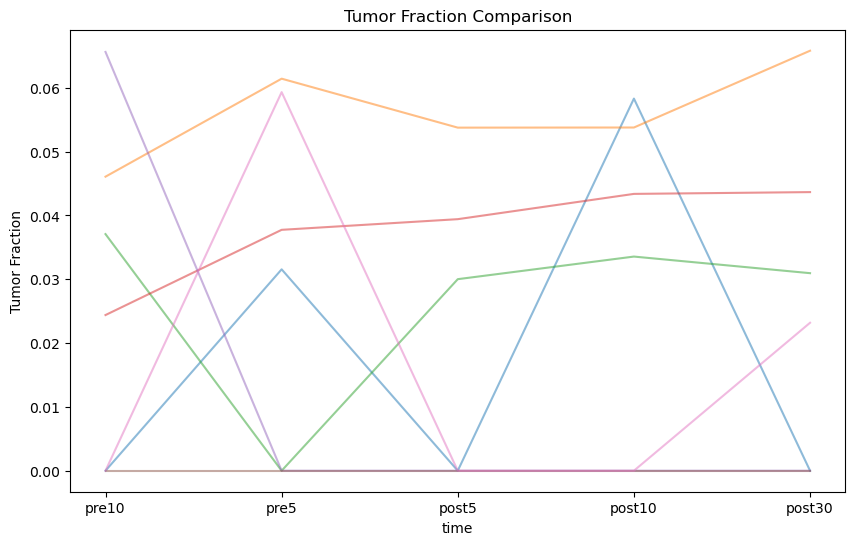

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def flexible_paired_plot(df_list, labels):
    # Assume df_list is a list of DataFrames
    # Each DataFrame has a 'library' and 'tumor_fraction' column

    for i, df in enumerate(df_list):
        df['base_sample'] = df['library'].str.extract(r'(\w{3})')  # Extract common base sample

    # Merge all DataFrames on the 'base_sample' column
    paired_df = df_list[0][['base_sample', 'tumor_fraction']].rename(columns={'tumor_fraction': f'tumor_fraction_{labels[0]}'})
    

    for i, df in enumerate(df_list[1:], 1):
        paired_df = pd.merge(paired_df, df[['base_sample', 'tumor_fraction']], on='base_sample', suffixes=('', f'_{labels[i]}'))
        paired_df = paired_df.rename(columns={'tumor_fraction': f'tumor_fraction_{labels[i]}'})

    display(paired_df)
    # Melt the DataFrame into long form for plotting
    value_vars = [f'tumor_fraction_{label}' for label in labels]
    plot_df = pd.melt(paired_df, id_vars='base_sample', value_vars=value_vars, 
                      var_name='time', value_name='tumor_fraction')

    # Map the 'time' variable to readable labels
    plot_df['time'] = plot_df['time'].map({f'tumor_fraction_{label}': label for label in labels})

    # Plotting
    plt.figure(figsize=(10, 6))

    # Using pointplot for the mean and line to show connection between pairs
    sns.pointplot(x='time', y='tumor_fraction', data=plot_df, join=False, errorbar=None, markers='d', scale=0, color='black')

    # Plot connections between the tumor fractions for each sample across all time points
    for i in range(len(paired_df)):
        plt.plot(range(len(labels)), paired_df.iloc[i, 1:].values, alpha=0.5)

    #plt.ylim(0, 0.07)  # You can adjust the y-axis limit as needed
    plt.title("Tumor Fraction Comparison")
    plt.ylabel('Tumor Fraction')
    plt.show()
flexible_paired_plot([pre10, pre5,post5,post10,post30], ['pre10','pre5','post5','post10','post30'])

,base_sample,tumor_fraction_pre10,tumor_fraction_pre5,tumor_fraction_post5,tumor_fraction_post10,tumor_fraction_post30
0,H05,0.05294,0.00000,NaN,0.00000,0.04209
1,H06,0.00000,0.03155,0.00000,0.05830,0.00000
2,H07,0.04607,0.06142,0.05375,0.05377,0.06580
3,H08,0.03707,0.00000,0.03001,0.03355,0.03095
4,H09,0.02439,0.03774,0.03941,0.04337,0.04365
5,H10,0.06561,0.00000,0.00000,0.00000,0.00000
6,H11,0.00000,0.00000,0.00000,0.00000,0.00000
7,H12,0.00000,0.05931,0.00000,0.00000,0.02318
8,H13,0.05537,0.07208,NaN,0.03998,0.05501
9,H01,NaN,0.00000,NaN,NaN,0.06461


/var/folders/2f/dgzn6jc90s7b4k56lfc468600000gq/T/ipykernel_1951/3241849028.py:39: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x='time', y='tumor_fraction', data=plot_df, join=False, errorbar=None, markers='d', scale=0, color='black')
/var/folders/2f/dgzn6jc90s7b4k56lfc468600000gq/T/ipykernel_1951/3241849028.py:39: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='time', y='tumor_fraction', data=plot_df, join=False, errorbar=None, markers='d', scale=0, color='black')


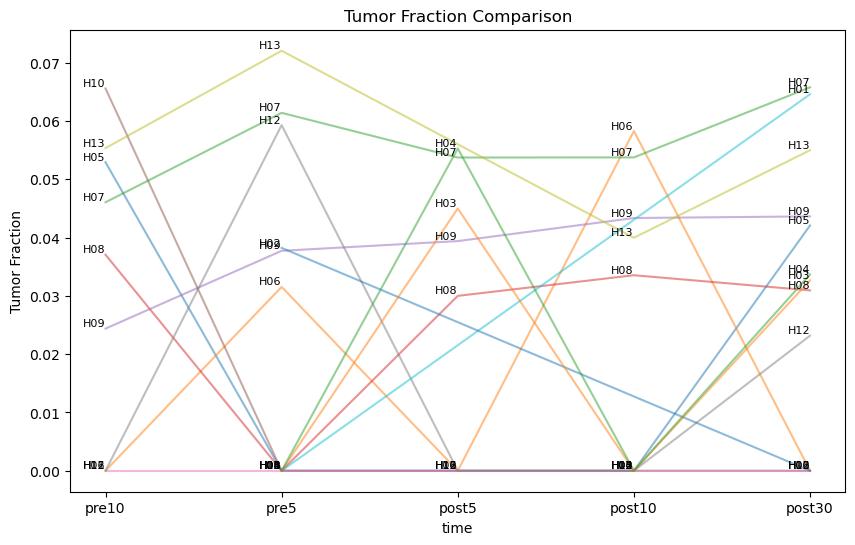

In [6]:


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def flexible_paired_plot_ALL(df_list, labels, save_path= None):
    # Assume df_list is a list of DataFrames
    # Each DataFrame has a 'library' and 'tumor_fraction' column

    # Extract base sample from each DataFrame
    for i, df in enumerate(df_list):
        df['base_sample'] = df['library'].str.extract(r'(\w{3})')

    # Perform outer merge to keep all samples from all DataFrames
    paired_df = df_list[0][['base_sample', 'tumor_fraction']].rename(columns={'tumor_fraction': f'tumor_fraction_{labels[0]}'})

    for i, df in enumerate(df_list[1:], 1):
        paired_df = pd.merge(paired_df, 
                             df[['base_sample', 'tumor_fraction']], 
                             on='base_sample', 
                             how='outer',  # Keep all base samples
                             suffixes=('', f'_{labels[i]}'))
        paired_df = paired_df.rename(columns={'tumor_fraction': f'tumor_fraction_{labels[i]}'})

    display(paired_df)

    # Melt the DataFrame into long form for plotting
    value_vars = [f'tumor_fraction_{label}' for label in labels]
    plot_df = pd.melt(paired_df, id_vars='base_sample', value_vars=value_vars, 
                      var_name='time', value_name='tumor_fraction')

    # Map the 'time' variable to readable labels
    plot_df['time'] = plot_df['time'].map({f'tumor_fraction_{label}': label for label in labels})

    # Plotting
    plt.figure(figsize=(10, 6))

    # Using pointplot for the mean and line to show connection between pairs
    sns.pointplot(x='time', y='tumor_fraction', data=plot_df, join=False, errorbar=None, markers='d', scale=0, color='black')

    # Plot connections between the tumor fractions for each sample across all time points
    for i, row in paired_df.iterrows():
        x_values = []
        y_values = []
        for j, value in enumerate(row[1:].values):
            if not pd.isna(value):  # Only consider non-missing values for plotting
                x_values.append(j)
                y_values.append(value)
                plt.text(j, value, row['base_sample'], fontsize=8, ha='right', va='bottom')  # Add label to the plot

        # Now plot the line connecting the non-missing points
        if len(x_values) > 1:
            plt.plot(x_values, y_values, alpha=0.5)

    plt.title("Tumor Fraction Comparison")
    plt.ylabel('Tumor Fraction')
    
    # Save the plot if save_path is provided
    if save_path:
        paired_df.to_csv(save_path+"_paired.txt", index=False, sep='\t')
        plt.savefig(save_path+".png", bbox_inches='tight', dpi=300)  # Save with specified file path, adjust dpi for quality
    
    plt.show()
   

flexible_paired_plot_ALL([pre10, pre5,post5,post10,post30], ['pre10','pre5','post5','post10','post30'], save_path=ichroCNA_file)

,base_sample,tumor_fraction_pre10,tumor_fraction_pre5,tumor_fraction_post5,tumor_fraction_post10,tumor_fraction_post30
0,H05,0.05294,0.00000,NaN,0.00000,0.04209
1,H06,0.00000,0.03155,0.00000,0.05830,0.00000
2,H07,0.04607,0.06142,0.05375,0.05377,0.06580
3,H08,0.03707,0.00000,0.03001,0.03355,0.03095
4,H09,0.02439,0.03774,0.03941,0.04337,0.04365
5,H10,0.06561,0.00000,0.00000,0.00000,0.00000
6,H11,0.00000,0.00000,0.00000,0.00000,0.00000
7,H12,0.00000,0.05931,0.00000,0.00000,0.02318
8,H13,0.05537,0.07208,NaN,0.03998,0.05501
9,H01,NaN,0.00000,NaN,NaN,0.06461


/var/folders/2f/dgzn6jc90s7b4k56lfc468600000gq/T/ipykernel_1951/1885990103.py:39: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x='time', y='tumor_fraction', data=plot_df, join=False, errorbar=None, markers='d', scale=0, color='black')
/var/folders/2f/dgzn6jc90s7b4k56lfc468600000gq/T/ipykernel_1951/1885990103.py:39: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='time', y='tumor_fraction', data=plot_df, join=False, errorbar=None, markers='d', scale=0, color='black')


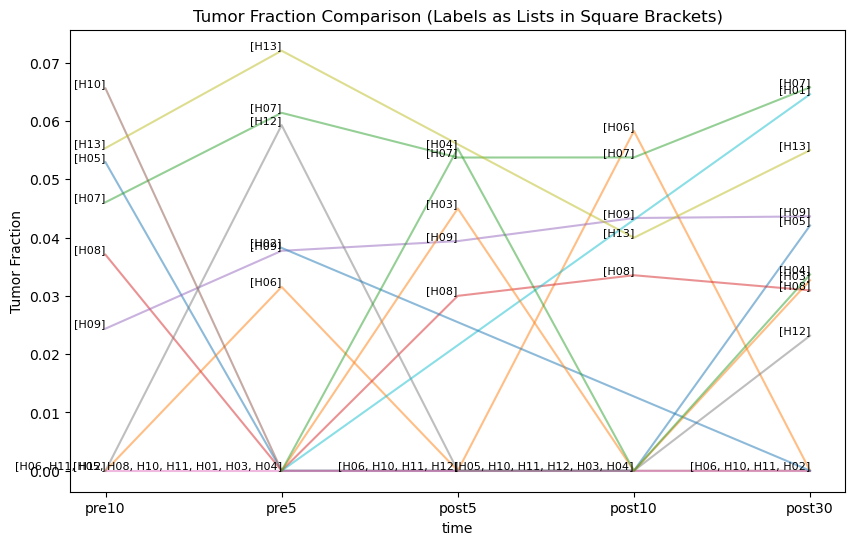

In [7]:


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def flexible_paired_plot_ALL(df_list, labels):
    # Assume df_list is a list of DataFrames
    # Each DataFrame has a 'library' and 'tumor_fraction' column

    # Extract base sample from each DataFrame
    for i, df in enumerate(df_list):
        df['base_sample'] = df['library'].str.extract(r'(\w{3})')

    # Perform outer merge to keep all samples from all DataFrames
    paired_df = df_list[0][['base_sample', 'tumor_fraction']].rename(columns={'tumor_fraction': f'tumor_fraction_{labels[0]}'})

    for i, df in enumerate(df_list[1:], 1):
        paired_df = pd.merge(paired_df, 
                             df[['base_sample', 'tumor_fraction']], 
                             on='base_sample', 
                             how='outer',  # Keep all base samples
                             suffixes=('', f'_{labels[i]}'))
        paired_df = paired_df.rename(columns={'tumor_fraction': f'tumor_fraction_{labels[i]}'})

    display(paired_df)

    # Melt the DataFrame into long form for plotting
    value_vars = [f'tumor_fraction_{label}' for label in labels]
    plot_df = pd.melt(paired_df, id_vars='base_sample', value_vars=value_vars, 
                      var_name='time', value_name='tumor_fraction')

    # Map the 'time' variable to readable labels
    plot_df['time'] = plot_df['time'].map({f'tumor_fraction_{label}': label for label in labels})

    # Plotting
    plt.figure(figsize=(10, 6))

    # Using pointplot for the mean and line to show connection between pairs
    sns.pointplot(x='time', y='tumor_fraction', data=plot_df, join=False, errorbar=None, markers='d', scale=0, color='black')

    # Dictionary to store labels at each x, y position (comma-separated)
    label_positions = {}

    # Plot connections between the tumor fractions for each sample across all time points
    for i, row in paired_df.iterrows():
        x_values = []
        y_values = []
        for j, value in enumerate(row[1:].values):
            if not pd.isna(value):  # Only consider non-missing values for plotting
                x_values.append(j)
                y_values.append(value)

                # Create a unique key for each (x, y) position
                position_key = (j, value)
                if position_key not in label_positions:
                    label_positions[position_key] = []
                
                # Append the base_sample to the list at that position
                label_positions[position_key].append(row['base_sample'])

        # Now plot the line connecting the non-missing points
        if len(x_values) > 1:
            plt.plot(x_values, y_values, alpha=0.5)

    # Add labels as comma-separated lists within square brackets
    for (x, y), base_samples in label_positions.items():
        label_text = '[' + ', '.join(base_samples) + ']'
        plt.text(x, y, label_text, fontsize=8, ha='right', va='bottom')

    plt.title("Tumor Fraction Comparison (Labels as Lists in Square Brackets)")
    plt.ylabel('Tumor Fraction')
    plt.show()


flexible_paired_plot_ALL([pre10, pre5,post5,post10,post30], ['pre10','pre5','post5','post10','post30'])

,base_sample,tumor_fraction_pre10,tumor_fraction_pre5,tumor_fraction_post5,tumor_fraction_post10,tumor_fraction_post30
0,H06,0.00000,0.03155,0.00000,0.05830,0.00000
1,H07,0.04607,0.06142,0.05375,0.05377,0.06580
2,H08,0.03707,0.00000,0.03001,0.03355,0.03095
3,H09,0.02439,0.03774,0.03941,0.04337,0.04365
4,H10,0.06561,0.00000,0.00000,0.00000,0.00000
5,H11,0.00000,0.00000,0.00000,0.00000,0.00000
6,H12,0.00000,0.05931,0.00000,0.00000,0.02318


/var/folders/2f/dgzn6jc90s7b4k56lfc468600000gq/T/ipykernel_1951/985331126.py:30: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x='time', y='tumor_fraction', data=plot_df, join=False, errorbar=None, markers='d', scale=0, color='black')
/var/folders/2f/dgzn6jc90s7b4k56lfc468600000gq/T/ipykernel_1951/985331126.py:30: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='time', y='tumor_fraction', data=plot_df, join=False, errorbar=None, markers='d', scale=0, color='black')


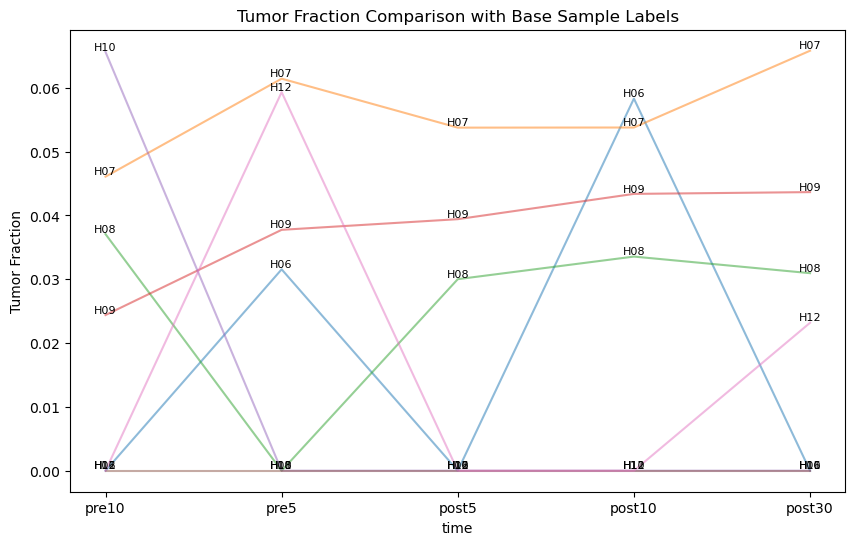

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def flexible_paired_plot_with_labels(df_list, labels):
    # Extract base sample from each DataFrame
    for i, df in enumerate(df_list):
        df['base_sample'] = df['library'].str.extract(r'(\w{3})')

    # Merge all DataFrames on the 'base_sample' column
    paired_df = df_list[0][['base_sample', 'tumor_fraction']].rename(columns={'tumor_fraction': f'tumor_fraction_{labels[0]}'})
    for i, df in enumerate(df_list[1:], 1):
        paired_df = pd.merge(paired_df, df[['base_sample', 'tumor_fraction']], on='base_sample', suffixes=('', f'_{labels[i]}'))
        paired_df = paired_df.rename(columns={'tumor_fraction': f'tumor_fraction_{labels[i]}'})

    
    display(paired_df)
    # Melt the DataFrame into long form for plotting
    value_vars = [f'tumor_fraction_{label}' for label in labels]
    plot_df = pd.melt(paired_df, id_vars='base_sample', value_vars=value_vars, 
                      var_name='time', value_name='tumor_fraction')

    # Map the 'time' variable to readable labels
    plot_df['time'] = plot_df['time'].map({f'tumor_fraction_{label}': label for label in labels})

    # Plotting
    plt.figure(figsize=(10, 6))

    # Using pointplot for the mean and line to show connection between pairs
    sns.pointplot(x='time', y='tumor_fraction', data=plot_df, join=False, errorbar=None, markers='d', scale=0, color='black')

    # Plot connections between the tumor fractions for each sample across all time points
    for i in range(len(paired_df)):
        plt.plot(range(len(labels)), paired_df.iloc[i, 1:].values, alpha=0.5)
        
        # Adding labels for each point using base_sample
        for j, label in enumerate(labels):
            plt.text(j, paired_df.iloc[i, j+1], paired_df['base_sample'].iloc[i], 
                     fontsize=8, ha='center', va='bottom')

    #plt.ylim(0, 0.08)  # You can adjust the y-axis limit as needed
    plt.title("Tumor Fraction Comparison with Base Sample Labels")
    plt.ylabel('Tumor Fraction')
    plt.show()
flexible_paired_plot_with_labels([pre10, pre5,post5,post10,post30], ['pre10','pre5','post5','post10','post30'])